# Business Understanding

Tanzania is a developing country in eastern Africa. It is a geographically diverse country with mountainous terrain and flat plains. The country borders the Indian Ocean in the east, and the Great Rift Valley on its western border. A good portion of the country is below sea level, and much of it is 900 ft above sea level. Water is a tricky resource in the country and many organizations have installed water pumps in villages around the country in an effort to provide clean drinking water to the poeple. These pumps vary in how they extract water, the water quality, and what basin the water comes from. Pumps break down and require maintenance which can be quite a task considering there are over 57,000 pumps in the country.

We have been asked by the Tanzanian Government to create a predicition model that will predict the condition of a water pump; functional, or non-functional. This will allow them strategically mobilize repair teams and to efficiently react when resources are needed in a particular area, such as supplying potable water to a village whose pump is non-functional and needs repair.

#### Our null hypothesis is that we are not able to predict whether a well is functional or not.

#### Our alternative hypothesis is that we can predict the condition of a well.

> A false positive would be to predict a well is functional when it is not.

> A false negative would be to predict a well is non-functional when it is.

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import yellowbrick as yb
import folium
sns.set(style="whitegrid")
pd.set_option('display.max_columns',None)

from scipy import stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [2]:
V = pd.read_csv('Data/values.csv')
y = pd.read_csv('Data/labels.csv')

In [3]:
y = y.replace({'status_group': {'functional' : 0, 'non functional' : 1, 'functional needs repair' : 1}})

In [4]:
y.status_group.value_counts()

0    32259
1    27141
Name: status_group, dtype: int64

In [5]:
df_lat_long = V['latitude'].to_frame().join(V['longitude']).join(y)
map_center = [df_lat_long['latitude'].mean(), df_lat_long['longitude'].mean()]

In [6]:
# map1 = folium.Map(location = map_center, tiles='Openstreetmap', zoom_start = 5, control_scale=True, prefer_canvas=True)
# for index, loc in df_lat_long.iterrows():
#     if loc['status_group']==0:
#         color = 'green'
#     elif loc['status_group']==1:
#         color = "red"
#     elif loc['status_group']==2:
#         color = 'blue'
#     else:
#         color = 'black'
#     folium.CircleMarker([loc['latitude'], loc['longitude']], radius=2, weight=1, popup=loc['id'], fill_color=color, stroke=False).add_to(map1)
# folium.LayerControl().add_to(map1)

# map1

In [7]:
df_all = V.join(y.set_index('id'), on='id')

In [8]:
df_all.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0


In [9]:
df_all.drop(labels=df_all.id[49651], inplace=True)

In [10]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59399 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59399 non-null  int64  
 1   amount_tsh             59399 non-null  float64
 2   date_recorded          59399 non-null  object 
 3   funder                 55764 non-null  object 
 4   gps_height             59399 non-null  int64  
 5   installer              55744 non-null  object 
 6   longitude              59399 non-null  float64
 7   latitude               59399 non-null  float64
 8   wpt_name               59399 non-null  object 
 9   num_private            59399 non-null  int64  
 10  basin                  59399 non-null  object 
 11  subvillage             59028 non-null  object 
 12  region                 59399 non-null  object 
 13  region_code            59399 non-null  int64  
 14  district_code          59399 non-null  int64  
 15  lg

In [11]:
# Need to drop features that have no influence, and are repetitive
df = df_all.drop(columns=['id', 'amount_tsh', 'date_recorded', 'funder',
       'longitude', 'latitude', 'wpt_name', 'num_private',
       'subvillage', 'region', 'region_code', 'district_code',
       'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 
       'extraction_type_group', 'extraction_type_class',
       'management_group', 'payment', 'payment_type',
       'quality_group', 'quantity', 'quantity_group',
       'source_type', 'source_class',
       'waterpoint_type_group'])

In [12]:
df.head()

,gps_height,installer,basin,lga,population,construction_year,extraction_type,management,water_quality,source,waterpoint_type,status_group
0,1390,Roman,Lake Nyasa,Ludewa,109,1999,gravity,vwc,soft,spring,communal standpipe,0
1,1399,GRUMETI,Lake Victoria,Serengeti,280,2010,gravity,wug,soft,rainwater harvesting,communal standpipe,0
2,686,World vision,Pangani,Simanjiro,250,2009,gravity,vwc,soft,dam,communal standpipe multiple,0
3,263,UNICEF,Ruvuma / Southern Coast,Nanyumbu,58,1986,submersible,vwc,soft,machine dbh,communal standpipe multiple,1
4,0,Artisan,Lake Victoria,Karagwe,0,0,gravity,other,soft,rainwater harvesting,communal standpipe,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59399 entries, 0 to 59399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gps_height         59399 non-null  int64 
 1   installer          55744 non-null  object
 2   basin              59399 non-null  object
 3   lga                59399 non-null  object
 4   population         59399 non-null  int64 
 5   construction_year  59399 non-null  int64 
 6   extraction_type    59399 non-null  object
 7   management         59399 non-null  object
 8   water_quality      59399 non-null  object
 9   source             59399 non-null  object
 10  waterpoint_type    59399 non-null  object
 11  status_group       59399 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 5.9+ MB


In [14]:
df.duplicated().value_counts()

False    43196
True     16203
dtype: int64

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
df.isna().sum().sum()

1640

In [17]:
df.dropna(inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41556 entries, 0 to 59399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gps_height         41556 non-null  int64 
 1   installer          41556 non-null  object
 2   basin              41556 non-null  object
 3   lga                41556 non-null  object
 4   population         41556 non-null  int64 
 5   construction_year  41556 non-null  int64 
 6   extraction_type    41556 non-null  object
 7   management         41556 non-null  object
 8   water_quality      41556 non-null  object
 9   source             41556 non-null  object
 10  waterpoint_type    41556 non-null  object
 11  status_group       41556 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 4.1+ MB


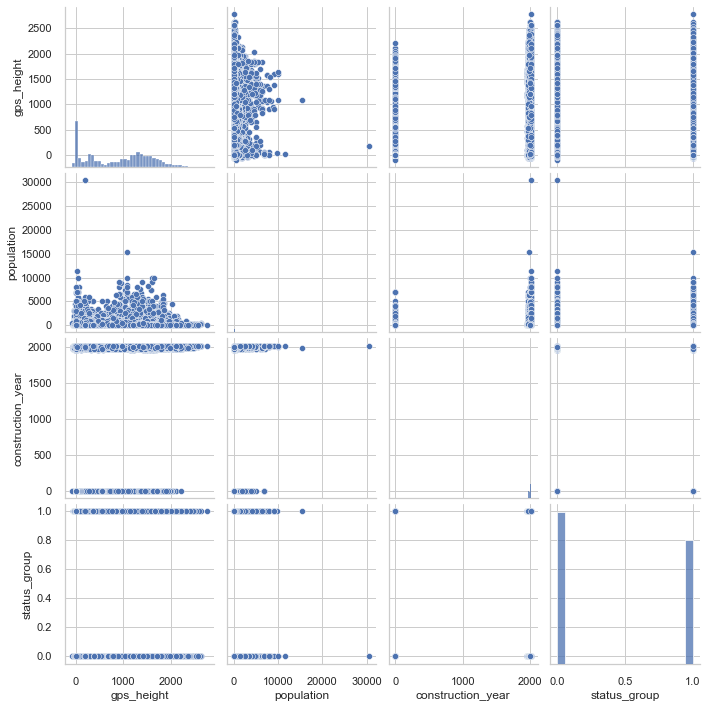

In [19]:
sns.pairplot(df)

In [20]:
X = df.drop('status_group', axis=1)
y = df.status_group

In [21]:
X_cat = X.select_dtypes('object')

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

dums = ohe.fit_transform(X_cat)
dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_cat.index)

In [22]:
X_nums = X.select_dtypes('int64')

In [23]:
X = pd.concat([X_nums, dums_df], axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [25]:
# X_train.population.where(X_train.population != 0, X_train.population.median(), inplace=True)

In [26]:
X_train.population.value_counts()

1       5245
0       5202
200     1620
150     1593
250     1448
        ... 
1439       1
4145       1
3241       1
5200       1
538        1
Name: population, Length: 995, dtype: int64

In [27]:
X_train.gps_height.value_counts()

 0       4410
-15        51
 303       47
-13        46
-16        46
         ... 
 2342       1
-57         1
 2391       1
 2120       1
 2413       1
Name: gps_height, Length: 2409, dtype: int64

In [28]:
X_train.gps_height.median()

1000.5

In [29]:
X_train.construction_year.median()

1998.0

In [30]:
X_train.construction_year.where(X_train.construction_year != 0, X_train.construction_year.median(), inplace=True)

/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [31]:
X_train.construction_year.value_counts()

1998    5378
2008    2289
2009    2232
2010    2195
2007    1391
2000    1370
2006    1298
2003    1149
2011    1106
2004     986
2012     962
2002     928
2005     899
1995     892
1978     888
1999     884
1985     798
1996     725
1984     688
1994     657
1982     653
1972     616
1990     589
1997     569
1992     569
1974     568
1980     554
1993     554
2001     480
1988     470
1983     428
1986     393
1975     371
1976     349
1991     291
1970     280
1989     277
1987     266
1981     204
1977     182
1979     170
1973     162
2013     154
1971     122
1963      76
1967      71
1968      68
1969      49
1960      40
1964      30
1962      27
1961      19
1965      17
1966      17
Name: construction_year, dtype: int64

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37400 entries, 31009 to 21130
Columns: 2331 entries, gps_height to x7_other
dtypes: float64(2328), int64(3)
memory usage: 665.4 MB


In [33]:
X_train_nums = X_train.select_dtypes('int64')

ss = StandardScaler()

ss.fit(X_train_nums)
nums_df = pd.DataFrame(ss.transform(X_train_nums),
                      index=X_train_nums.index)

In [34]:
X_cats = X_train.select_dtypes('float64')

In [35]:
X_train_clean = pd.concat([nums_df, X_cats], axis=1)

In [36]:
# X_test.population.where(X_test.population != 0, X_test.population.median(), inplace=True)

In [37]:
X_test.construction_year.where(X_test.construction_year != 0, X_test.construction_year.median(), inplace=True)

/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [38]:
X_test_nums = X_test.select_dtypes('int64')

ss = StandardScaler()

ss.fit(X_test_nums)
test_nums_df = pd.DataFrame(ss.transform(X_test_nums),
                      index=X_test_nums.index)

In [39]:
X_test_cats = X_test.select_dtypes('float64')

In [40]:
X_test_clean = pd.concat([test_nums_df, X_test_cats], axis=1)

In [41]:
X_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37400 entries, 31009 to 21130
Columns: 2331 entries, 0 to x7_other
dtypes: float64(2331)
memory usage: 665.4 MB


In [42]:
X_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4156 entries, 48942 to 34924
Columns: 2331 entries, 0 to x7_other
dtypes: float64(2331)
memory usage: 73.9 MB


# Logistic Regression

In [43]:
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')
model_log = logreg.fit(X_train_clean, y_train)
model_log

LogisticRegression(fit_intercept=False, solver='liblinear')

In [44]:
y_hat_train = logreg.predict(X_train_clean)
y_hat_test = logreg.predict(X_test_clean)

In [45]:
print(f"training accuracy: {model_log.score(X_train_clean, y_train)}")

training accuracy: 0.7463368983957219


In [46]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, y_hat_train))

[[17223  3382]
 [ 6105 10690]]


In [47]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
precision = precision_score(y_test, y_hat_test)
recall = recall_score(y_test, y_hat_test)
accuracy = accuracy_score(y_test, y_hat_test)
F1 = f1_score(y_test, y_hat_test)

In [48]:
print(precision)
print(accuracy)
print(recall)
print(F1)

0.7302672467371037
0.7264196342637151
0.6256656017039404
0.6739317464869515


# KNN

In [49]:
neigh = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
neigh.fit(X_train_clean, y_train)

KNeighborsClassifier(metric='manhattan')

In [ ]:
knn_preds = neigh.predict(X_train_clean)

In [ ]:
print(f"training accuracy: {neigh.score(X_train_clean, y_train)}")

In [ ]:
print(confusion_matrix(y_train, knn_preds))

In [ ]:
knn_test_preds = neigh.predict(X_test_clean)

In [ ]:
print(f"testing accuracy: {neigh.score(X_test_clean, y_test)}")

In [ ]:
print(confusion_matrix(y_test, knn_test_preds))

In [ ]:
from yellowbrick.classifier import confusion_matrix

visualizer = confusion_matrix(neigh, X_test_clean, y_test, cmap='Reds')

In [ ]:
precision = precision_score(y_test, knn_test_preds)
recall = recall_score(y_test, knn_test_preds)
accuracy = accuracy_score(y_test, knn_test_preds)
F1 = f1_score(y_test, knn_test_preds)

In [ ]:
print(precision)
print(accuracy)
print(recall)
print(F1)

In [ ]:
X_t, X_val, y_t, y_val = train_test_split(X_train_clean, y_train,
                                          test_size=0.1)

knn_val = KNeighborsClassifier()

knn_val.fit(X_t, y_t)
print(f"training accuracy: {knn_val.score(X_t, y_t)}")
print(f"validation accuracy: {knn_val.score(X_val, y_val)}")

y_hat_val = knn_val.predict(X_val)

print(confusion_matrix(knn_val, X_val, y_val))

In [ ]:
precision = precision_score(y_val, y_hat_val)
recall = recall_score(y_val, y_hat_val)
accuracy = accuracy_score(y_val, y_hat_val)
F1 = f1_score(y_val, y_hat_val)

print(precision)
print(accuracy)
print(recall)
print(F1)

# Naive Bayes

In [ ]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)

gnb.predict(X_test_clean)

gnb.score(X_test_clean, y_test)

# Decision Tree

In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=4, criterion='gini')

tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X_test_clean)

accuracy_score(y_test, y_pred)